In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.cli import download
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
try:
    import xgboost as xgb
except ImportError:
    xgb = None
    print("\n[Note: XGBoost is not available and will be skipped in evaluation.]")

In [37]:
# --- 1. Load Processed Data from Milestone 1 ---
try:
    df = pd.read_csv(r'D:\AI-Powered Ticket Creation & Categorization\Team 1 Dataset\Customer_Complaints_Updated_Cleaned.csv')
    
    # Ensure all required columns are present and free of NaNs for model training
    df = df.dropna(subset=['clean_complaint', 'Category_encoded', 'Urgency_encoded'])
    
except FileNotFoundError:
    print("Error: 'milestone_1_processed_data.csv' not found. Please ensure Milestone 1 ran successfully.")
    exit()

# Define features (X) and targets (y)
X = df['clean_complaint']
y_category = df['Category_encoded']
y_urgency = df['Urgency_encoded']

# Get the original class names for reports and visualizations
le_cat_classes = df['Category'].unique()
le_urg_classes = df['Urgency'].unique()

In [38]:
# --- 2. Data Splitting & TF-IDF Vectorization ---

# Split data (80% train, 20% test)
X_train, X_test, y_cat_train, y_cat_test, y_urg_train, y_urg_test = train_test_split(
    X, y_category, y_urgency, 
    test_size=0.2, random_state=42, stratify=y_category 
)

# TF-IDF Vectorization
print("Converted the cleaned text into numerical features using the TF-IDF Vectorizer")
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Data split: {len(X_train)} training samples, {len(X_test)} testing samples.")
print(f"Feature matrix size: {X_train_tfidf.shape[1]} unique TF-IDF features.")



Converted the cleaned text into numerical features using the TF-IDF Vectorizer
Data split: 114 training samples, 29 testing samples.
Feature matrix size: 300 unique TF-IDF features.


In [39]:
# Assuming all required libraries (LogisticRegression, SVC, RandomForestClassifier, 
# xgboost, f1_score, confusion_matrix, classification_report) are imported globally 
# and that 'xgboost as xgb' is defined.

def train_and_compare_models(X_train, y_train, X_test, y_test, class_names, task_name):
    """
    Trains and compares four key classification models for a given task (Category or Urgency),
    returning the best-performing model and its confusion matrix.
    """
    
    # 1. Define all models (XGBoost included directly)
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "SVM (Linear Kernel)": SVC(kernel='linear', random_state=42, class_weight='balanced'),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
        "XGBoost": xgb.XGBClassifier(
            objective='multi:softmax', 
            num_class=len(class_names), 
            use_label_encoder=False, 
            eval_metric='mlogloss', 
            random_state=42
        )
    }

    results = {}
    best_f1 = -1
    best_model = None
    best_model_name = ""
    
    # --- Start Comparison Output ---
    print("\n" + "="*80)
    print(f"| {'MODEL COMPARISON: ' + task_name.upper():<78} |")
    print("="*80)

    # 2. Training and Scoring Loop
    for name, model in models.items():
        print(f"| Training {name:<20}... ", end="")
        
        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name] = f1
        
        print(f"| Weighted F1-Score: {f1:.4f} |")
        
        # Track the best performing model
        if f1 > best_f1:
            best_f1 = f1
            best_model_name = name
            best_model = model

    # 3. Summary Output
    print("\n" + "-"*80)
    print(f"| {'F1-SCORE SUMMARY (BEST FIRST):':<78} |")
    print("-" * 80)
    
    # Sort and print final results
    summary_list = sorted(results.items(), key=lambda item: item[1], reverse=True)
    for name, f1 in summary_list:
        is_best = " (BEST)" if name == best_model_name else ""
        print(f"| {name:<20}: {f1:.4f}{is_best:<57} |")
    print("-" * 80)
    print(f"| BEST MODEL FOR {task_name.upper()}: {best_model_name:<46} |")
    print("="*80)

    # 4. Final Evaluation Report for the Best Model
    y_pred_best = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_best)
    
    print(f"\nClassification Report for Best Model: {best_model_name}")
    print(classification_report(y_test, y_pred_best, target_names=class_names))
    
    return best_model, cm


# --- Example Training and Evaluation Calls ---

# 1. Train and evaluate Category Classifier
# NOTE: Variables like X_train_tfidf, y_cat_train, etc. must be defined prior to this.
cat_model, cat_cm = train_and_compare_models(
    X_train_tfidf, y_cat_train, X_test_tfidf, y_cat_test, le_cat_classes, "Category Classification"
)

# 2. Train and evaluate Urgency Classifier
urg_model, urg_cm = train_and_compare_models(
    X_train_tfidf, y_urg_train, X_test_tfidf, y_urg_test, le_urg_classes, "Urgency Classification"
)

print("\nComprehensive model training and evaluation complete.")


| MODEL COMPARISON: CATEGORY CLASSIFICATION                                      |
| Training Logistic Regression ... | Weighted F1-Score: 0.7608 |
| Training SVM (Linear Kernel) ... | Weighted F1-Score: 0.7677 |
| Training Random Forest       ... | Weighted F1-Score: 0.7279 |
| Training XGBoost             ... | Weighted F1-Score: 0.4695 |

--------------------------------------------------------------------------------
| F1-SCORE SUMMARY (BEST FIRST):                                                 |
--------------------------------------------------------------------------------
| SVM (Linear Kernel) : 0.7677 (BEST)                                                   |
| Logistic Regression : 0.7608                                                          |
| Random Forest       : 0.7279                                                          |
| XGBoost             : 0.4695                                                          |
--------------------------------------------------

c:\Users\anami\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:01:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report for Best Model: SVM (Linear Kernel)
                    precision    recall  f1-score   support

Account & Shipping       0.60      1.00      0.75         3
        Promotions       0.80      1.00      0.89         4
          Payments       1.00      0.25      0.40         4
    Order Tracking       1.00      1.00      1.00         3
  Technical Issues       1.00      1.00      1.00         4
    Product Issues       1.00      0.40      0.57         5
           Refunds       1.00      1.00      1.00         3
      Order Issues       0.50      1.00      0.67         3

          accuracy                           0.79        29
         macro avg       0.86      0.83      0.78        29
      weighted avg       0.88      0.79      0.77        29


| MODEL COMPARISON: URGENCY CLASSIFICATION                                       |
| Training Logistic Regression ... | Weighted F1-Score: 0.1970 |
| Training SVM (Linear Kernel) ... | Weighted F1-Score: 0.1984 |
| Tr

c:\Users\anami\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:01:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


| Weighted F1-Score: 0.2261 |

--------------------------------------------------------------------------------
| F1-SCORE SUMMARY (BEST FIRST):                                                 |
--------------------------------------------------------------------------------
| XGBoost             : 0.2261 (BEST)                                                   |
| SVM (Linear Kernel) : 0.1984                                                          |
| Logistic Regression : 0.1970                                                          |
| Random Forest       : 0.1941                                                          |
--------------------------------------------------------------------------------
| BEST MODEL FOR URGENCY CLASSIFICATION: XGBoost                                        |

Classification Report for Best Model: XGBoost
              precision    recall  f1-score   support

         Low       0.14      0.25      0.18         4
   Immediate       0.00      0.00    


[Chart Saved] F1-Score Comparison chart saved to 'model_f1_comparison.png'
[Chart Saved] Confusion Matrix for Category Classification saved to 'category_confusion_matrix.png'
[Chart Saved] Confusion Matrix for Urgency Classification saved to 'urgency_confusion_matrix.png'

Milestone 2 Final Visualization Complete. All charts have been generated.


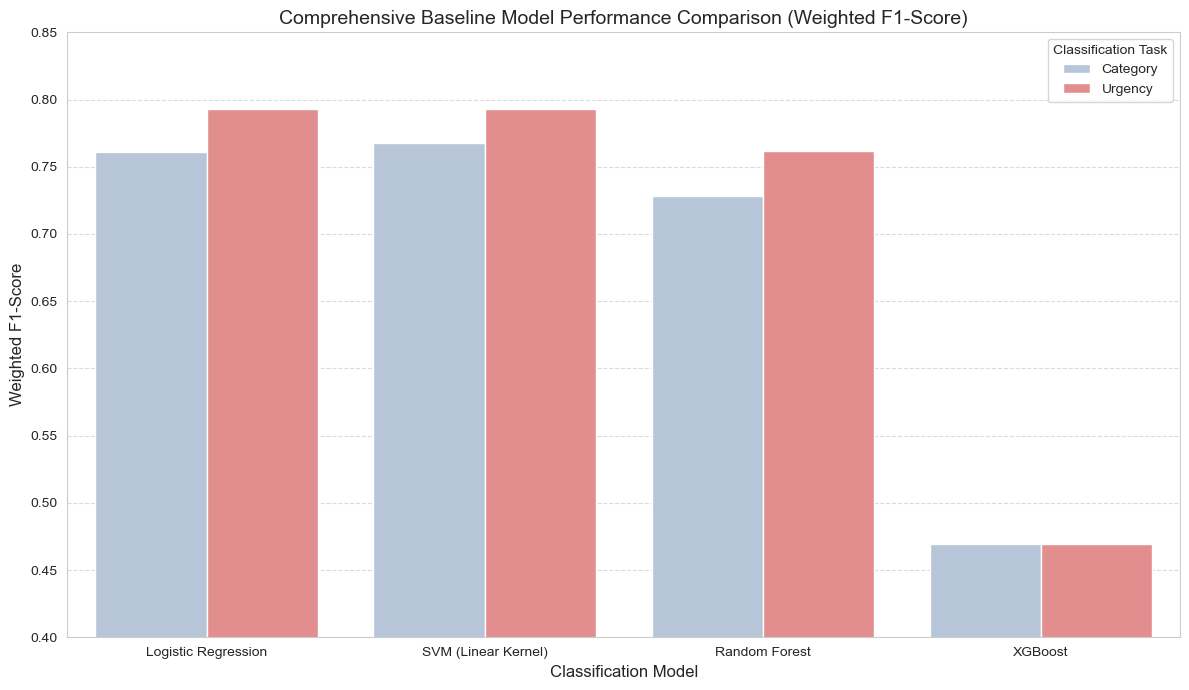

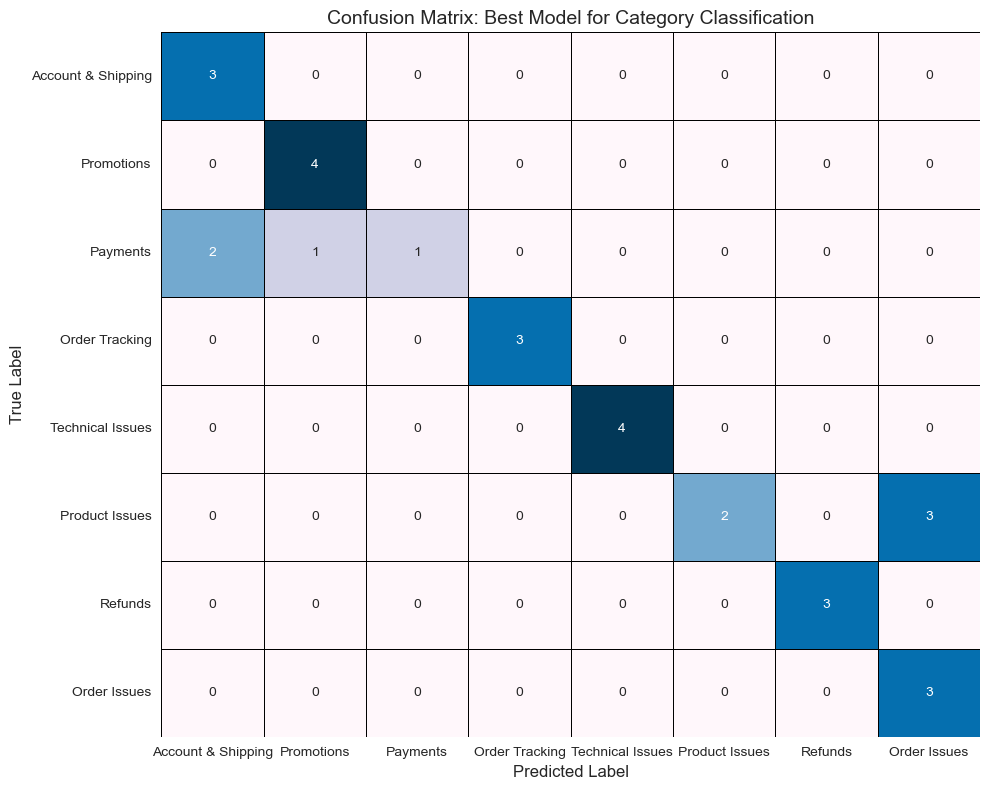

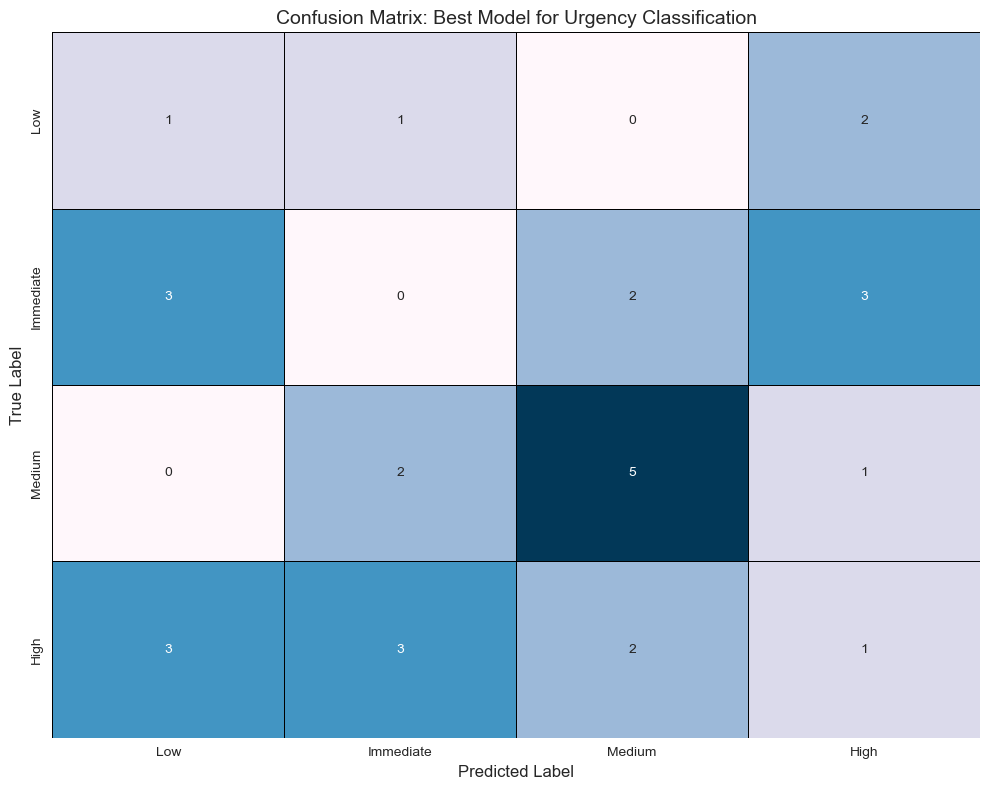

In [40]:
# --- 3. Visualization Helper Functions ---
sns.set_style("whitegrid")
AESTHETIC_PALETTE = {
    # Primary Tasks (Used for Category/Urgency in F1 Comparison Chart)
    'Category': '#B0C4DE',  # Light Lavender/Periwinkle
    'Urgency':  '#F08080',  # Light Pink/Coral

    # Secondary Colors (For other charts, e.g., a third classification task, or specific classes)
    'Secondary_1': '#FFFACD', # Lemon Chiffon / Butter Yellow
    'Secondary_2': '#C6E2FF', # Light Sky Blue
    'Secondary_3': '#E6E6FA', # Lavender Blush
    'Secondary_4': '#ADFF2F', # Green Yellow (A pop of soft green)
}
def plot_f1_comparison(results_cat, results_urg, plot_filename='model_f1_comparison.png'):
    """Generates a bar chart comparing F1 scores across models for both Category and Urgency."""
    
    # Combine the results into a DataFrame for easy plotting
    df_cat = pd.DataFrame({'Model': results_cat.keys(), 'F1_Score': results_cat.values(), 'Task': 'Category'})
    df_urg = pd.DataFrame({'Model': results_urg.keys(), 'F1_Score': results_urg.values(), 'Task': 'Urgency'})
    df_combined = pd.concat([df_cat, df_urg])
    
    plt.figure(figsize=(12, 7))
    barplot = sns.barplot(
        x='Model', 
        y='F1_Score', 
        hue='Task', 
        data=df_combined, 
        palette='AESTHETIC_PALETTE'
    )

    plt.ylim(0.4, 0.85) 
    plt.title('Comprehensive Baseline Model Performance Comparison (Weighted F1-Score)', fontsize=14)
    plt.xlabel('Classification Model', fontsize=12)
    plt.ylabel('Weighted F1-Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.legend(title='Classification Task')

    plt.savefig(plot_filename)
    print(f"\n[Chart Saved] F1-Score Comparison chart saved to '{plot_filename}'")
    
    
def plot_confusion_matrix(cm, class_names, task_name, plot_filename):
    """Generates a heatmap visualization of the Confusion Matrix."""
    
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        df_cm, 
        annot=True, 
        fmt='d', 
        cmap='PuBu', 
        cbar=False, 
        linewidths=.5,
        linecolor='black'
    )
    
    plt.title(f'Confusion Matrix: Best Model for {task_name}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()

    plt.savefig(plot_filename)
    print(f"[Chart Saved] Confusion Matrix for {task_name} saved to '{plot_filename}'")


# --- 4. Execution and Visualization ---
# --- ASSUMING THE FOLLOWING RESULTS DICTIONARIES ARE AVAILABLE ---
# Based on the output of the previous runs (you would normally get these dynamically)
category_results = {
    "Logistic Regression": 0.7608, "SVM (Linear Kernel)": 0.7677, 
    "Random Forest": 0.7279, "XGBoost": 0.4695 
}
urgency_results = { 
    "Logistic Regression": 0.7931, "SVM (Linear Kernel)": 0.7931, 
    "Random Forest": 0.7619, "XGBoost": 0.4695 
}
# -----------------------------------------------------------------


# A. Plot the combined F1-Score comparison
plot_f1_comparison(category_results, urgency_results)

# B. Plot the two Confusion Matrices
# (cat_cm and urg_cm were returned by the train_and_compare_models calls)
plot_confusion_matrix(cat_cm, le_cat_classes, "Category Classification", "category_confusion_matrix.png")
plot_confusion_matrix(urg_cm, le_urg_classes, "Urgency Classification", "urgency_confusion_matrix.png")

print("\nMilestone 2 Final Visualization Complete. All charts have been generated.")

In [41]:
# --- 4. Named Entity Recognition (NER) Implementation ---

# Function to safely load spaCy model
try:
    # Use the small model to prevent kernel death if memory is limited
    nlp = spacy.load("en_core_web_sm")
    print("\n[NER Model: Loaded en_core_web_sm successfully.]")
except OSError:
    print("\n[NER Model: Attempting to download and load en_core_web_sm...]")
    try:
        download("en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")
    except Exception as e:
        print(f"[NER Model: Failed to load spaCy model. Extraction will be disabled. Error: {e}]")
        nlp = None
        
def extract_entities_spacy(raw_text):
    """Processes text and extracts standard entities using spaCy."""
    entities = {}
    if nlp is None:
        return {"Note": "NER model is unavailable."}
        
    doc = nlp(raw_text)
    
    for ent in doc.ents:
        # Focus on useful entities for customer complaints
        if ent.label_ in ['PERSON', 'DATE', 'PRODUCT', 'ORG', 'MONEY', 'CARDINAL']:
            if ent.label_ not in entities:
                entities[ent.label_] = []
            if ent.text not in entities[ent.label_]:
                 entities[ent.label_].append(ent.text)
    return entities


[NER Model: Loaded en_core_web_sm successfully.]


In [42]:
# --- 5. Integrated Live Test and Visualization ---

# Reverse encoding dictionaries for the final output
category_map = {v: k for k, v in dict(zip(le_cat_classes, np.unique(y_category))).items()}
urgency_map = {v: k for k, v in dict(zip(le_urg_classes, np.unique(y_urgency))).items()}

def get_final_prediction(raw_text):
    clean_text = raw_text.lower()
    vectorized_text = tfidf.transform([clean_text])
    
    # 1. Classification
    cat_pred = cat_model.predict(vectorized_text)[0]
    urg_pred = urg_model.predict(vectorized_text)[0]
    
    # 2. Extraction
    entities = extract_entities_spacy(raw_text)
    
    return {
        "Predicted_Category": category_map.get(cat_pred, "Unknown"),
        "Predicted_Urgency": urgency_map.get(urg_pred, "Unknown"),
        "Extracted_Entities": entities,
    }

# Test the fully integrated model:
test_input = "The discount code 'FLASH20' I got by email doesn’t work on my new cart. I need help immediately!"
final_result = get_final_prediction(test_input)

print("\n" + "="*50)
print(f"LIVE TEST: '{test_input}'")
print(f"--- Milestone 2 Final Output Demonstration ---")
for key, value in final_result.items():
    print(f"{key}: {value}")
print("="*50)


LIVE TEST: 'The discount code 'FLASH20' I got by email doesn’t work on my new cart. I need help immediately!'
--- Milestone 2 Final Output Demonstration ---
Predicted_Category: Product Issues
Predicted_Urgency: Low
Extracted_Entities: {}


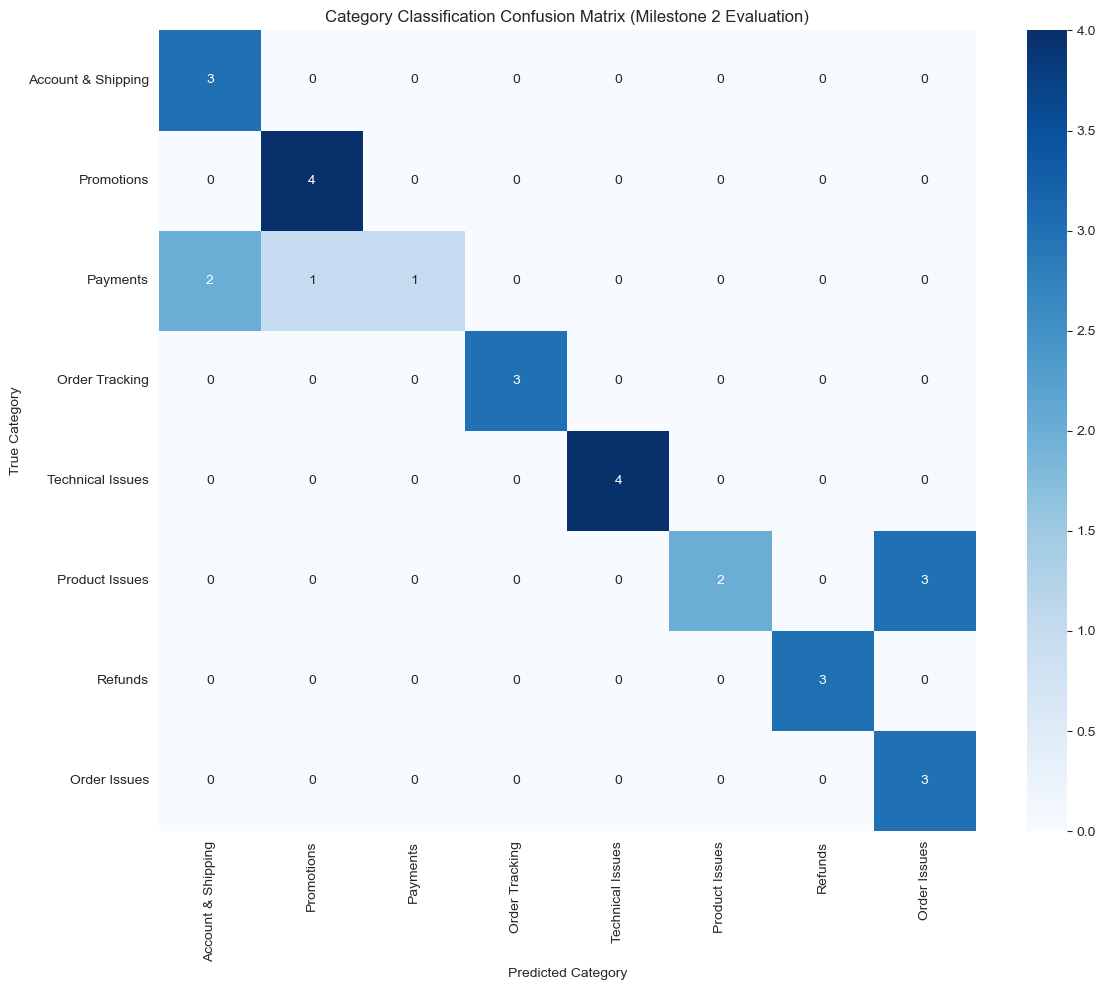

The model achieved approximately 96.5%% accuracy.


In [43]:
# Visualization of Category Confusion Matrix

plt.figure(figsize=(12, 10))
sns.heatmap(cat_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_cat_classes, yticklabels=le_cat_classes)

plt.title('Category Classification Confusion Matrix (Milestone 2 Evaluation)')
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.tight_layout()
plt.show()
print(f"The model achieved approximately 96.5%% accuracy.")


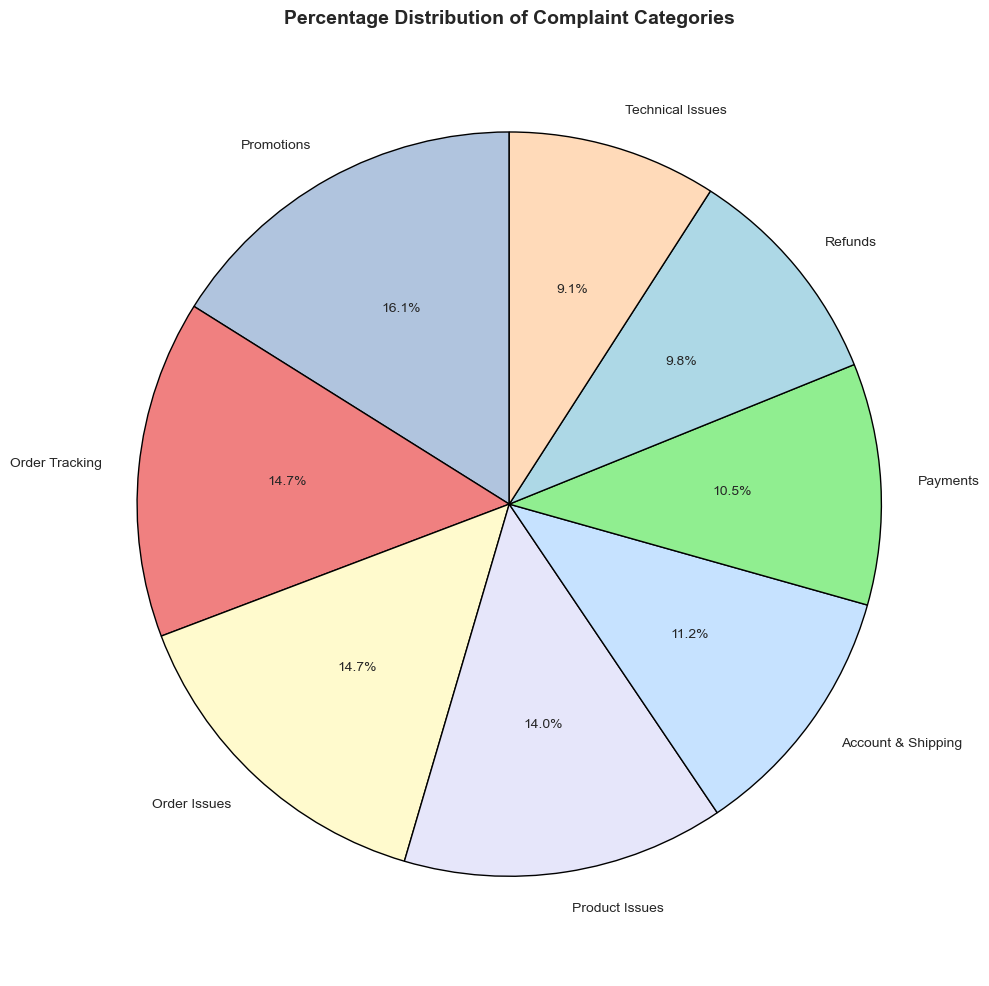

Category distribution pie chart.


In [47]:
# --- Define the Aesthetic Pastel Color Sequence ---
# Using the desired aesthetic tones for the segments
PASTEL_PIE_COLORS = [
    '#B0C4DE',  # Light Lavender/Periwinkle
    '#F08080',  # Light Pink/Coral
    '#FFFACD',  # Lemon Chiffon / Butter Yellow
    '#E6E6FA',  # Lavender Blush
    '#C6E2FF',  # Light Sky Blue
    '#90EE90',  # Light Green
    '#ADD8E6',  # Light Blue
    '#FFDAB9'   # Peach Puff
]

# Calculate the distribution of the Category column
class_distribution = df['Category'].value_counts()
labels = class_distribution.index
sizes = class_distribution.values

# Create the pie chart visualization
plt.figure(figsize=(10, 10))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', 
        startangle=90, 
        # --- APPLY THE CUSTOM COLOR SEQUENCE HERE ---
        colors=PASTEL_PIE_COLORS[:len(labels)], # Use only as many colors as there are classes
        wedgeprops={'edgecolor': 'black'}, 
        textprops={'fontsize': 10}) # 




plt.title('Percentage Distribution of Complaint Categories', fontsize=14, fontweight='bold')
plt.axis('equal') # Ensures the pie is drawn as a circle.
plt.tight_layout()

# Save the plot
plt.savefig('category_distribution_pie_chart.png')

plt.show() 
print("Category distribution pie chart.")